In [354]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [355]:
def f(x):
    return 3*x**2 - 4*x + 5

In [356]:
f(2.0)

9.0

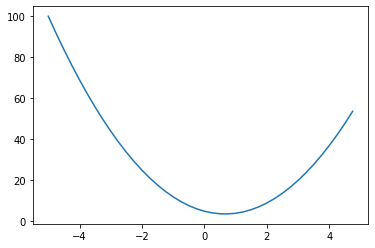

In [357]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [358]:
h = 0.001
x = 3.0
f(x)

20.0

In [359]:
f(x+h)

20.014003000000002

In [360]:
(f(x+h)-f(x))/h

14.00300000000243

In [361]:
a = 2.0
b = -3.0
c = 10.0

d = a*b+c
print(d)

4.0


In [362]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
d2 = (a+h)*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [583]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward  
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), _op='tanh')
        
        def _backward():
            self.grad += (1-(t**2)) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [501]:
a = Value(3.0, label='a')
a

Value(data=3.0)

In [502]:
b = Value(-2.0, label='b')
b

Value(data=-2.0)

In [503]:
a+b

Value(data=1.0)

In [504]:
c = Value(10.0, label='c')

In [505]:
d = a*b; d.label='d'

In [506]:
d

Value(data=-6.0)

In [507]:
d._prev

(Value(data=3.0), Value(data=-2.0))

In [508]:
e = d+c; e.label='e' 

In [509]:
e

Value(data=4.0)

In [510]:
f = Value(2.0, label='f')

In [511]:
f

Value(data=2.0)

In [512]:
L = e*f; L.label='L'
L

Value(data=8.0)

In [513]:
def print_leaf(v):
    print(f'Label: {v.label}, Value: {v.data}')

def print_node(v):
    print(f'Label: {v.label}, Value: {v.data}, Children: 1) {v._prev[0].label}={v._prev[0].data}, 2) {v._prev[1].label}={v._prev[1].data}, Operator: {v._op}')
         


print(f'Label: {L.label}, Value: {L.data}, Children: 1) {L._prev[0].label}={L._prev[0].data}, 2) {L._prev[1].label}={L._prev[1].data}, Operator: {L._op}')

if len(L._prev)>0:
    for child in L._prev:
        if child._op == '':
            print_leaf(child)
        else:
            print_node(child)

Label: L, Value: 8.0, Children: 1) e=4.0, 2) f=2.0, Operator: *
Label: e, Value: 4.0, Children: 1) d=-6.0, 2) c=10.0, Operator: +
Label: f, Value: 2.0


In [514]:
def draw_tree(v, lvl=0):
    sp = lvl * '    '
    if v._op != '':
        print(f'{sp}--> ({lvl}) | {v.label} | data={v.data} | grad={v.grad} [{v._op}]')
        
        for child in v._prev:
            draw_tree(child, lvl=lvl+1)
    else:
        print(f'{sp}--> ({lvl}) | {v.label} | data={v.data} | grad={v.grad} [leaf]')

In [515]:
draw_tree(L)

--> (0) | L | data=8.0 | grad=0.0 [*]
    --> (1) | e | data=4.0 | grad=0.0 [+]
        --> (2) | d | data=-6.0 | grad=0.0 [*]
            --> (3) | a | data=3.0 | grad=0.0 [leaf]
            --> (3) | b | data=-2.0 | grad=0.0 [leaf]
        --> (2) | c | data=10.0 | grad=0.0 [leaf]
    --> (1) | f | data=2.0 | grad=0.0 [leaf]


In [516]:
#dL/df = (e*(f+h) - e*f)/h
#dL/df = (e*f + e*h - e*f)/h
#dL/df = (e*h)/h
#dL/df = e

In [517]:
L.grad = 1.0
f.grad = 4.0
e.grad = 2.0

In [518]:
#dL/dc --> chain rule

#de/dc --> e = d+c
#de/dc = ((d+c+h) - (d+c))/h
#de/dc = (d+c+h-d-c)/h
#de/dc = h/h
#de/dc = 1

#dL/dc = dL/de * de/dc
#dL/dc = 2.0 * 1.0

In [519]:
c.grad = 2.0

In [520]:
d.grad = 2.0

In [521]:
draw_tree(L)

--> (0) | L | data=8.0 | grad=1.0 [*]
    --> (1) | e | data=4.0 | grad=2.0 [+]
        --> (2) | d | data=-6.0 | grad=2.0 [*]
            --> (3) | a | data=3.0 | grad=0.0 [leaf]
            --> (3) | b | data=-2.0 | grad=0.0 [leaf]
        --> (2) | c | data=10.0 | grad=2.0 [leaf]
    --> (1) | f | data=2.0 | grad=4.0 [leaf]


In [522]:
#print(e._prev[1] is c)

In [523]:
#dL/da --> chain rule
#dL/da = dL/dd * dd/da
#dd/da = (((a+h)*b)-(a*b))/h
#dd/da = (a*b + h*b - a*b)/h
#dd/da = (h*b)/h
#dd/da = b

#dL/da = b * 2.0

In [524]:
a.grad = -4.0

In [525]:
b.grad = 6.0

In [526]:
draw_tree(L)

--> (0) | L | data=8.0 | grad=1.0 [*]
    --> (1) | e | data=4.0 | grad=2.0 [+]
        --> (2) | d | data=-6.0 | grad=2.0 [*]
            --> (3) | a | data=3.0 | grad=-4.0 [leaf]
            --> (3) | b | data=-2.0 | grad=6.0 [leaf]
        --> (2) | c | data=10.0 | grad=2.0 [leaf]
    --> (1) | f | data=2.0 | grad=4.0 [leaf]


In [527]:
#Let's go up with L

In [528]:
L

Value(data=8.0)

In [529]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a*b
e = d+c
L = e*f
L

Value(data=8.726303999999999)

In [530]:
#Neuron

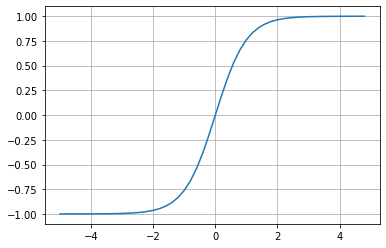

In [531]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [551]:
#neuron
#data (inputs)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#inner values
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#neuron raw value (without activation function)
n = x1w1x2w2 + b; n.label='n'

#activation function tanh
o = n.tanh(); o.label = 'o'

In [552]:
draw_tree(n)

--> (0) | n | data=0.8813735870195432 | grad=0.0 [+]
    --> (1) | x1w1 + x2w2 | data=-6.0 | grad=0.0 [+]
        --> (2) | x1w1 | data=-6.0 | grad=0.0 [*]
            --> (3) | x1 | data=2.0 | grad=0.0 [leaf]
            --> (3) | w1 | data=-3.0 | grad=0.0 [leaf]
        --> (2) | x2w2 | data=0.0 | grad=0.0 [*]
            --> (3) | x2 | data=0.0 | grad=0.0 [leaf]
            --> (3) | w2 | data=1.0 | grad=0.0 [leaf]
    --> (1) | b | data=6.881373587019543 | grad=0.0 [leaf]


In [553]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=0.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.0 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.0 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.0 [*]
                --> (4) | x1 | data=2.0 | grad=0.0 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.0 [*]
                --> (4) | x2 | data=0.0 | grad=0.0 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.0 [leaf]


In [535]:
o.grad = 1.0

In [536]:
#o=tanh(n)
#do/dn = 1-(tanh(n))^2
#do/dn = 1-o**2
#do/dn = 1 - 

In [537]:
1 - o.data**2

0.4999999999999999

In [538]:
n.grad = 0.5

In [539]:
b.grad = 0.5

In [540]:
x1w1x2w2.grad = 0.5

In [541]:
x1w1.grad = 0.5

In [542]:
x2w2.grad = 0.5

In [543]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [544]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [545]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.5 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.5 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.5 [*]
                --> (4) | x1 | data=2.0 | grad=-1.5 [leaf]
                --> (4) | w1 | data=-3.0 | grad=1.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.5 [*]
                --> (4) | x2 | data=0.0 | grad=0.5 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.5 [leaf]


In [546]:
# By _backward

In [554]:
o.grad = 1.0

In [555]:
o._backward

<function __main__.Value.tanh.<locals>._backward()>

In [556]:
o._backward()

In [557]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.4999999999999999 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.0 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.0 [*]
                --> (4) | x1 | data=2.0 | grad=0.0 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.0 [*]
                --> (4) | x2 | data=0.0 | grad=0.0 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.0 [leaf]


In [558]:
n._backward()

In [559]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.4999999999999999 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.4999999999999999 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.0 [*]
                --> (4) | x1 | data=2.0 | grad=0.0 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.0 [*]
                --> (4) | x2 | data=0.0 | grad=0.0 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.4999999999999999 [leaf]


In [560]:
x1w1x2w2._backward()

In [561]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.4999999999999999 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.4999999999999999 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.4999999999999999 [*]
                --> (4) | x1 | data=2.0 | grad=0.0 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.4999999999999999 [*]
                --> (4) | x2 | data=0.0 | grad=0.0 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.4999999999999999 [leaf]


In [562]:
x1w1._backward()

In [563]:
x2w2._backward()

In [564]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.4999999999999999 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.4999999999999999 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.4999999999999999 [*]
                --> (4) | x1 | data=2.0 | grad=-1.4999999999999996 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.9999999999999998 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.4999999999999999 [*]
                --> (4) | x2 | data=0.0 | grad=0.4999999999999999 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.4999999999999999 [leaf]


In [565]:
#Topological Sort

In [566]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [567]:
#neuron
#data (inputs)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#inner values
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#neuron raw value (without activation function)
n = x1w1x2w2 + b; n.label='n'

#activation function tanh
o = n.tanh(); o.label = 'o'

In [568]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=0.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.0 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.0 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.0 [*]
                --> (4) | x1 | data=2.0 | grad=0.0 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.0 [*]
                --> (4) | x2 | data=0.0 | grad=0.0 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.0 [leaf]


In [569]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

In [570]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.4999999999999999 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.4999999999999999 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.4999999999999999 [*]
                --> (4) | x1 | data=2.0 | grad=-1.4999999999999996 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.9999999999999998 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.4999999999999999 [*]
                --> (4) | x2 | data=0.0 | grad=0.4999999999999999 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.4999999999999999 [leaf]


In [572]:
#neuron
#data (inputs)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#inner values
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#neuron raw value (without activation function)
n = x1w1x2w2 + b; n.label='n'

#activation function tanh
o = n.tanh(); o.label = 'o'

In [573]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=0.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.0 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.0 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.0 [*]
                --> (4) | x1 | data=2.0 | grad=0.0 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.0 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.0 [*]
                --> (4) | x2 | data=0.0 | grad=0.0 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.0 [leaf]


In [574]:
o.backward()

In [575]:
draw_tree(o)

--> (0) | o | data=0.7071067811865476 | grad=1.0 [tanh]
    --> (1) | n | data=0.8813735870195432 | grad=0.4999999999999999 [+]
        --> (2) | x1w1 + x2w2 | data=-6.0 | grad=0.4999999999999999 [+]
            --> (3) | x1w1 | data=-6.0 | grad=0.4999999999999999 [*]
                --> (4) | x1 | data=2.0 | grad=-1.4999999999999996 [leaf]
                --> (4) | w1 | data=-3.0 | grad=0.9999999999999998 [leaf]
            --> (3) | x2w2 | data=0.0 | grad=0.4999999999999999 [*]
                --> (4) | x2 | data=0.0 | grad=0.4999999999999999 [leaf]
                --> (4) | w2 | data=1.0 | grad=0.0 [leaf]
        --> (2) | b | data=6.881373587019543 | grad=0.4999999999999999 [leaf]


In [584]:
x = Value(1.0)

In [585]:
y = x + x

In [586]:
y

Value(data=2.0)

In [587]:
draw_tree(y)

--> (0) |  | data=2.0 | grad=0.0 [+]
    --> (1) |  | data=1.0 | grad=0.0 [leaf]
    --> (1) |  | data=1.0 | grad=0.0 [leaf]


In [588]:
y.backward()

In [589]:
draw_tree(y)

--> (0) |  | data=2.0 | grad=1.0 [+]
    --> (1) |  | data=1.0 | grad=2.0 [leaf]
    --> (1) |  | data=1.0 | grad=2.0 [leaf]


In [590]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label='f'

f.backward()
draw_tree(f)

--> (0) | f | data=-6.0 | grad=1.0 [*]
    --> (1) | d | data=-6.0 | grad=1.0 [*]
        --> (2) | a | data=-2.0 | grad=-3.0 [leaf]
        --> (2) | b | data=3.0 | grad=-8.0 [leaf]
    --> (1) | e | data=1.0 | grad=-6.0 [+]
        --> (2) | a | data=-2.0 | grad=-3.0 [leaf]
        --> (2) | b | data=3.0 | grad=-8.0 [leaf]


In [591]:
#Let's do in in a proper way

In [635]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other): #other+self
        return self+other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward  
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        out = Value(self.data**other, (self,), _op=f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
            
        out._backward = _backward  
        return out
    
    def __rmul__(self, other): #other*self
        return self*other
    
    def __truediv__(self, other): #self/other
        out = self * other**-1
        return out
    
    def __neg__(self): #-self
        return self * (-1)
    
    def __sub__(self, other): #self-other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), _op='tanh')
        
        def _backward():
            self.grad += (1-(t**2)) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), _op='exp')
        
        def _backward():
            self.grad = out.data * out.grad #+=
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [636]:
1+Value(2.0)

Value(data=3.0)

In [637]:
1*Value(2.0)

Value(data=2.0)

In [638]:
#neuron
#data (inputs)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

#inner values
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

#neuron raw value (without activation function)
n = x1w1x2w2 + b; n.label='n'

#activation function tanh, but different calculation
e = (2*n).exp(); e.label='e'
o = (e-1)/(e+1); o.label = 'o'

#o.backward()
draw_tree(o)

--> (0) | o | data=0.7071067811865477 | grad=0.0 [*]
    --> (1) |  | data=4.828427124746192 | grad=0.0 [+]
        --> (2) | e | data=5.828427124746192 | grad=0.0 [exp]
            --> (3) |  | data=1.7627471740390863 | grad=0.0 [*]
                --> (4) | n | data=0.8813735870195432 | grad=0.0 [+]
                    --> (5) | x1w1 + x2w2 | data=-6.0 | grad=0.0 [+]
                        --> (6) | x1w1 | data=-6.0 | grad=0.0 [*]
                            --> (7) | x1 | data=2.0 | grad=0.0 [leaf]
                            --> (7) | w1 | data=-3.0 | grad=0.0 [leaf]
                        --> (6) | x2w2 | data=0.0 | grad=0.0 [*]
                            --> (7) | x2 | data=0.0 | grad=0.0 [leaf]
                            --> (7) | w2 | data=1.0 | grad=0.0 [leaf]
                    --> (5) | b | data=6.881373587019543 | grad=0.0 [leaf]
                --> (4) |  | data=2 | grad=0.0 [leaf]
        --> (2) |  | data=-1 | grad=0.0 [leaf]
    --> (1) |  | data=0.1464466094067262

In [639]:
o.backward()
draw_tree(o)

--> (0) | o | data=0.7071067811865477 | grad=1.0 [*]
    --> (1) |  | data=4.828427124746192 | grad=0.1464466094067262 [+]
        --> (2) | e | data=5.828427124746192 | grad=0.04289321881345247 [exp]
            --> (3) |  | data=1.7627471740390863 | grad=0.25 [*]
                --> (4) | n | data=0.8813735870195432 | grad=0.5 [+]
                    --> (5) | x1w1 + x2w2 | data=-6.0 | grad=0.5 [+]
                        --> (6) | x1w1 | data=-6.0 | grad=0.5 [*]
                            --> (7) | x1 | data=2.0 | grad=-1.5 [leaf]
                            --> (7) | w1 | data=-3.0 | grad=1.0 [leaf]
                        --> (6) | x2w2 | data=0.0 | grad=0.5 [*]
                            --> (7) | x2 | data=0.0 | grad=0.5 [leaf]
                            --> (7) | w2 | data=1.0 | grad=0.0 [leaf]
                    --> (5) | b | data=6.881373587019543 | grad=0.5 [leaf]
                --> (4) |  | data=2 | grad=0.2203433967548858 [leaf]
        --> (2) |  | data=-1 | grad=0.1

In [640]:
#In PyTorch

In [643]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True

n = x1*w1+x2*w2+b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [644]:
#class Neuron

In [649]:
import random

In [725]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        #w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [726]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

In [727]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)


Value(data=-0.36256741779298357)

In [728]:
n.w

[Value(data=0.8350331970840037), Value(data=-0.6219553325664091)]

In [729]:
n.b

Value(data=-0.18403914058012938)

In [730]:
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=0.7506416935704173),
 Value(data=-0.7560166592985756),
 Value(data=0.7712421887731167)]

In [731]:
[print(neu.w) for neu in n.neurons]

[Value(data=0.12895277702271235), Value(data=0.2734513642416927)]
[Value(data=-0.8476341011377386), Value(data=0.032240881330905635)]
[Value(data=-0.6049428795023988), Value(data=0.4718191326606409)]


[None, None, None]

In [747]:
class MLP(): #multi-layer perceptron 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for l in self.layers:
            p = l.parameters()
            params.extend(p)
        
        return params

In [733]:
[1] + [1, 2, 3]

[1, 1, 2, 3]

In [734]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.48766582722636526)

In [735]:
n.layers

In [736]:
draw_tree(n(x))

--> (0) |  | data=-0.48766582722636526 | grad=0.0 [tanh]
    --> (1) |  | data=-0.532993259180168 | grad=0.0 [+]
        --> (2) |  | data=-0.45341944762089675 | grad=0.0 [+]
            --> (3) |  | data=-0.858753073139016 | grad=0.0 [+]
                --> (4) |  | data=-0.2055236740230147 | grad=0.0 [+]
                    --> (5) |  | data=-0.31687621552453926 | grad=0.0 [leaf]
                    --> (5) |  | data=0.11135254150152456 | grad=0.0 [*]
                        --> (6) |  | data=0.22413086174344388 | grad=0.0 [leaf]
                        --> (6) |  | data=0.4968193163375537 | grad=0.0 [tanh]
                            --> (7) |  | data=0.5450741811573616 | grad=0.0 [+]
                                --> (8) |  | data=0.1261035735093753 | grad=0.0 [+]
                                    --> (9) |  | data=0.07285847671323831 | grad=0.0 [+]
                                        --> (10) |  | data=0.7617129567335563 | grad=0.0 [+]
                                     

In [737]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] #inputs (4 samples)

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [738]:
ypred = [n(x) for x in xs]
ypred #nn predictions for xs

[Value(data=-0.48766582722636526),
 Value(data=-0.12634288323562073),
 Value(data=0.1758906947940979),
 Value(data=-0.8393511282580918)]

In [739]:
#Loss

In [740]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.742357870297815)

In [741]:
loss.backward()

In [742]:
n.layers[0].neurons[0].w[0].grad

4.1019804653836

In [743]:
draw_tree(loss)

--> (0) |  | data=7.742357870297815 | grad=1.0 [+]
    --> (1) |  | data=4.3591452972735 | grad=1.0 [+]
        --> (2) |  | data=2.9764263711701537 | grad=1.0 [+]
            --> (3) |  | data=2.2131496134971056 | grad=1.0 [+]
                --> (4) |  | data=2.2131496134971056 | grad=1.0 [**2]
                    --> (5) |  | data=-1.4876658272263652 | grad=-2.9753316544527304 [+]
                        --> (6) |  | data=-0.48766582722636526 | grad=-2.9753316544527304 [tanh]
                            --> (7) |  | data=-0.532993259180168 | grad=-2.267744352910658 [+]
                                --> (8) |  | data=-0.45341944762089675 | grad=-2.267744352910658 [+]
                                    --> (9) |  | data=-0.858753073139016 | grad=-2.267744352910658 [+]
                                        --> (10) |  | data=-0.2055236740230147 | grad=-2.267744352910658 [+]
                                            --> (11) |  | data=-0.31687621552453926 | grad=0.643682836511107

In [748]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.5400082582379134)

In [749]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] #inputs (4 samples)

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [750]:
n.parameters()

[Value(data=-0.5094118375286034),
 Value(data=0.7354884450120653),
 Value(data=-0.9373133336520616),
 Value(data=-0.37035308449769855),
 Value(data=-0.3380974375113124),
 Value(data=-0.5251592958830675),
 Value(data=0.9496575338944242),
 Value(data=-0.3759734555700063),
 Value(data=0.494365151614915),
 Value(data=0.8720443117743542),
 Value(data=0.7897445705634991),
 Value(data=-0.5814610065913033),
 Value(data=0.34040222368488227),
 Value(data=-0.17994116973653385),
 Value(data=-0.8034156705636533),
 Value(data=0.5842267239300631),
 Value(data=-0.7387623023405112),
 Value(data=0.08363156845394992),
 Value(data=0.0418834244241304),
 Value(data=-0.35205046493832115),
 Value(data=0.006763878092306275),
 Value(data=0.16460681908793373),
 Value(data=0.6650566850889674),
 Value(data=0.9098236993162778),
 Value(data=0.5274549490638649),
 Value(data=0.9107680898833204),
 Value(data=-0.04076985723859705),
 Value(data=-0.07775307729879),
 Value(data=-0.678622844471964),
 Value(data=-0.337242953

In [751]:
ypred = [n(x) for x in xs]
ypred #nn predictions for xs

[Value(data=0.5400082582379134),
 Value(data=0.43301484420557346),
 Value(data=0.4200733563233908),
 Value(data=0.27461591112487327)]

In [752]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.80791435993562)

In [753]:
loss.backward()

In [754]:
n.layers[0].neurons[0].w[0].data

-0.5094118375286034

In [755]:
n.layers[0].neurons[0].w[0].grad

0.16091386451915626

In [756]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [757]:
n.layers[0].neurons[0].w[0].data

-0.5110209761737949

In [758]:
ypred = [n(x) for x in xs]
ypred #nn predictions for xs

[Value(data=0.5468547168173072),
 Value(data=0.2594735515856568),
 Value(data=0.26229950439405636),
 Value(data=0.27054466133841687)]

In [759]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.917119404709876)

In [761]:
epochs = 20

for e in range(epochs):
    #forward pass
    ypred = [n(x) for x in xs] #nn predictions for xs
    
    #calculate loss
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    #set grad to 0
    for p in n.parameters():
        p.grad = 0.0
    
    #calculate gradients
    loss.backward()
    
    #update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    #print current state
    print(f'Epoch: {e+1}/{epochs}, Loss: {loss.data}')

Epoch: 1/20, Loss: 0.03603036865254649
Epoch: 2/20, Loss: 0.03408796858472125
Epoch: 3/20, Loss: 0.03233613847735241
Epoch: 4/20, Loss: 0.030748602804075743
Epoch: 5/20, Loss: 0.029303659709693994
Epoch: 6/20, Loss: 0.027983233313070476
Epoch: 7/20, Loss: 0.02677215128187071
Epoch: 8/20, Loss: 0.025657587783892724
Epoch: 9/20, Loss: 0.0246286294091023
Epoch: 10/20, Loss: 0.023675933614209853
Epoch: 11/20, Loss: 0.02279145754255167
Epoch: 12/20, Loss: 0.021968240915880403
Epoch: 13/20, Loss: 0.02120023086252836
Epoch: 14/20, Loss: 0.020482139555007463
Epoch: 15/20, Loss: 0.019809327726416096
Epoch: 16/20, Loss: 0.019177708755237822
Epoch: 17/20, Loss: 0.01858366921511803
Epoch: 18/20, Loss: 0.01802400269368374
Epoch: 19/20, Loss: 0.017495854372666868
Epoch: 20/20, Loss: 0.016996674387750377


In [762]:
loss

Value(data=0.016996674387750377)

In [764]:
ypred

[Value(data=0.9622139124702827),
 Value(data=-0.93032252632859),
 Value(data=-0.933978004399785),
 Value(data=0.9202815470754602)]